#  P300 Speller Implementation
Welcome to the P300 Speller project! This repository contains a Python-based implementation of a brain-computer interface (BCI) application that uses the P300 event-related potential (ERP) to enable users to communicate by spelling characters through their brain activity.

###  Importing the necessary libraries and modules

###### MNE: A library for processing and visualizing EEG/MEG data

###### Pandas: Used for data manipulation and analysis

###### Seaborn: For advanced data visualization, particularly for exploring data distributions

###### NumPy: A library for numerical operations on arrays

###### MNE Decoding: Vectorizer is used to flatten multi-dimensional EEG data for machine learning pipelines

###### MNE IO: RawEDF allows reading EEG data in EDF format (a common format for EEG recordings)

###### PyRiemann: Provides tools for Riemannian geometry-based machine learning, often used with EEG data

###### Scikit-learn: Libraries for machine learning

###### MNE Preprocessing: ICA (Independent Component Analysis) is used for artifact removal (e.g., eye blinks, muscle activity)

###### Matplotlib: A library for creating static, interactive, and animated visualizations


In [5]:
import glob
from collections import OrderedDict

import mne
import pandas as pd
import seaborn as sns
import numpy as np
from mne.decoding import Vectorizer
from mne.io.edf.edf import RawEDF
from pyriemann.classification import MDM
from pyriemann.estimation import ERPCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.preprocessing import ICA
from matplotlib import pyplot as plt

In [6]:
files = glob.glob('../data/train_*.fif')
print(files)

['../data\\train_2023-10-13 16_25_26.000046_raw.fif', '../data\\train_2023-10-13 16_27_58.404136_raw.fif', '../data\\train_2023-10-13 16_30_37.410082_raw.fif', '../data\\train_2023-10-13 16_33_04.819831_raw.fif']


In [7]:
import sys
sys.path.append('/P300-Speller/p300')

from p300.config import EPOCHS_TMIN, EPOCHS_TMAX
from p300.speller.stimulus import StimulusHelper

ica = ICA(n_components=14, max_iter="auto", random_state=97)

epoch_list = []
for file in files:
    raw = mne.io.read_raw_fif(file, preload=True)  # type: RawEDF

    ica.fit(raw)
    ica.apply(raw)

    raw.filter(1, 30)
    events = mne.find_events(raw)

    event_id = StimulusHelper.get_train_event_id()
    epoch = mne.Epochs(raw, events, event_id, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, baseline=None, preload=True)
    epoch_list.append(epoch)

epochs = mne.concatenate_epochs(epoch_list)  # type: mne.Epochs
easycap_montage = mne.channels.make_standard_montage('easycap-M1')
epochs.set_montage(easycap_montage)
epochs.pick_types(eeg=True)

Opening raw data file ../data\train_2023-10-13 16_25_26.000046_raw.fif...
Isotrak not found
    Range : 0 ... 16227 =      0.000 ...    63.387 secs
Ready.
Reading 0 ... 16227  =      0.000 ...    63.387 secs...
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


C:\Users\user\AppData\Local\Temp\ipykernel_20376\2327735975.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

200 events found on stim channel STIM
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 155 original time points ...
1 bad epochs dropped
Open

C:\Users\user\AppData\Local\Temp\ipykernel_20376\2327735975.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)
200 events found on stim channel STIM
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 155 original time points ...
1 bad epochs dropped
Openi

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_20376\2327735975.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)
200 events found on stim channel STIM
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 155 original time po

C:\Users\user\AppData\Local\Temp\ipykernel_20376\2327735975.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

200 events found on stim channel STIM
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 155 original time points ...
1 bad epochs dropped
Not 

<EpochsArray | 796 events (all good), -0.102 – 0.5 s (baseline off), ~13.2 MB, data loaded,
 'Target': 117
 'NonTarget': 679>

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows


c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Averaging across epochs before plotting...


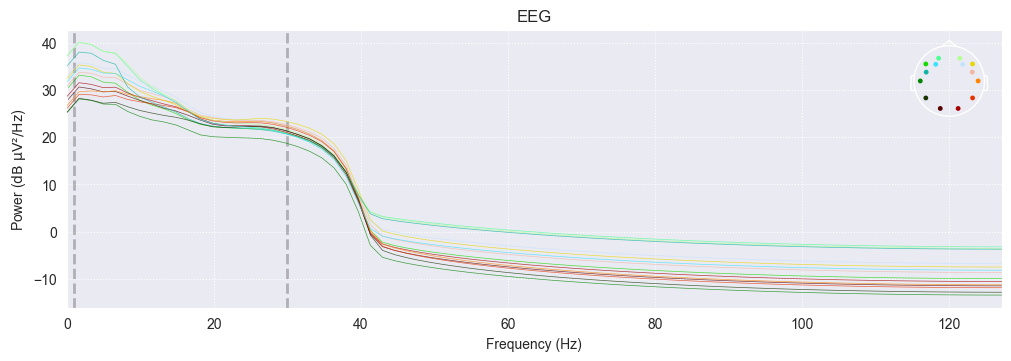

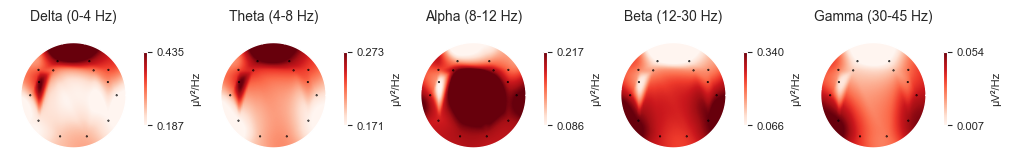

Using matplotlib as 2D backend.


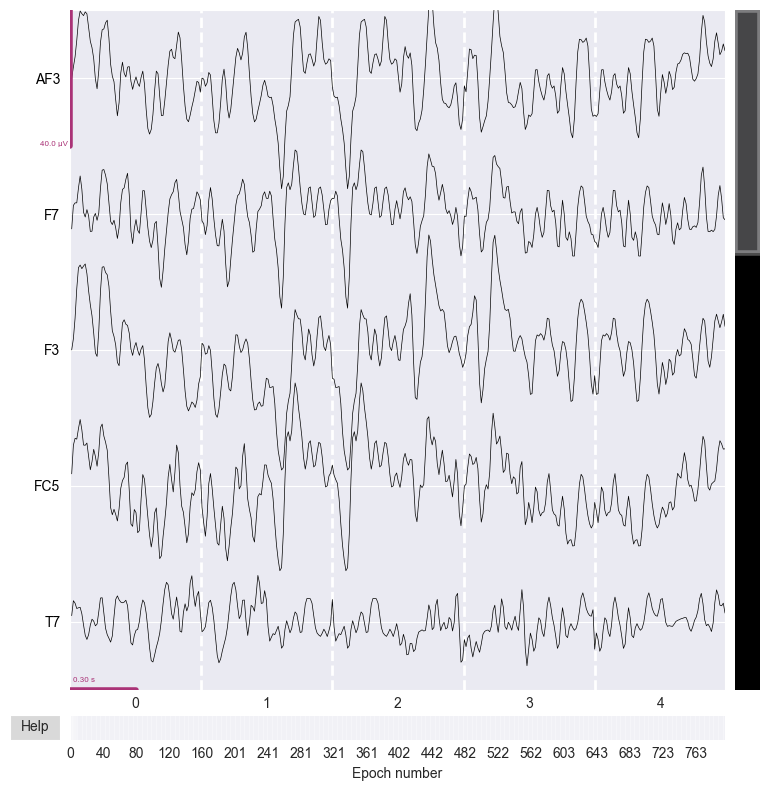

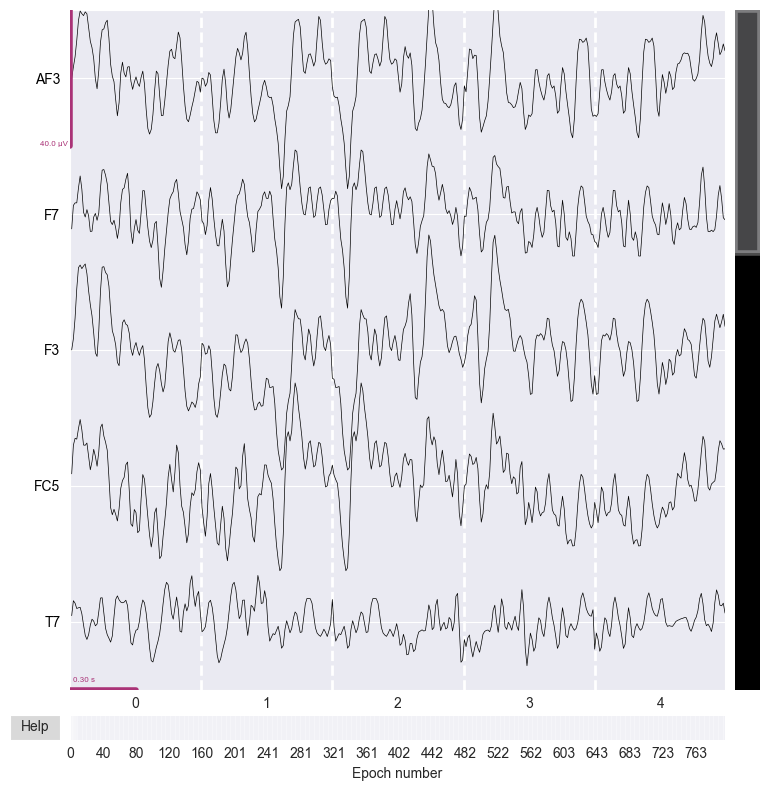

In [8]:
epochs.compute_psd().plot(average=False, picks="data", exclude="bads")
epochs.compute_psd().plot_topomap( normalize=True, contours=0)
epochs.plot(n_epochs=5, n_channels=5)